# Importamos las librerias








In [1]:
# 1. Importamos las librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words("english")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Cargamos el dataset

In [2]:
# 2. Cargamos el dataset
from google.colab import files

# Reemplazamos nuestro dataset de phishing
df = pd.read_csv('/content/CEAS_08.csv')
df.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


# Visualización previa de los datos

In [3]:
# 3. Imprimimos las filas, columnas y luego con info a traves de la etiqueta mostramos la cantidad de correos legitimos y spam.
print("Filas, Columnas:", df.shape)
df.info()
df["label"].value_counts()


Filas, Columnas: (39154, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


,count
label,
1,21842
0,17312


# Limpieza Básica

In [4]:
def clean_text(text):

    if isinstance(text, str) == False:
        text = str(text)

    # Convertimos todo a minúsculas
    text = text.lower()

    # Quitamos los URL del dataset
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Quitamos simbolos y caracteres especiales
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

    # Quitamos los números
    text = re.sub(r"\d+", "", text)

    # Eliminamos las conjugaciones y preposiciones
    words = [word for word in text.split() if word not in stopwords]
    text = " ".join(words)

    return text


# Aplicar limpieza a SUBJECT + BODY (los uniremos)


In [5]:

# limpiamos los asuntos de los correos
df["subject"] = df["subject"].astype(str).apply(clean_text)
# Limpiamos el contenido del correo
df["body"] = df["body"].astype(str).apply(clean_text)
# Unimos ambos textos en una sola columna llamada
df["unión de texto"] = df["subject"] + " " + df["body"]

df["unión de texto"].head()


,unión de texto
0,never agree loser buck troubles caused small d...
1,befriend jenna jameson upgrade sex pleasures t...
2,cnncom daily top daily top cnncom top videos s...
3,svn commit r spamassassintrunk libmailspamassa...
4,specialpricespharmmoreinfo welcomefastshipping...


# Vectorizar texto

In [6]:

# Vectorizamos el texto
# TF = frecuencia de una palabra en un correo
# IDF = qué tan rara es esa palabra en el dataset
# ax_features=1000 = usamos las 1000 palabras mas "relevantes"
tfidf = TfidfVectorizer(max_features=1000)
# Con esto ayudamos a evitar el overfitting y producimos un mejor modelo
X = tfidf.fit_transform(df["unión de texto"])
y = df["label"]


# Separar en entrenamiento / Test

In [7]:
# Aca a traves del rtest-size le decimos que un 20% sea de prueba y lo demas que sea de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


# Entrenamiento del modelo — Regresión Logística

In [8]:

# Entrenar modelo
# el C previene sobreajuste y el max iter bace que el modelo converge
model = LogisticRegression(max_iter=1000, C=0.1)
# aca ya estamos entrenando al modelo
model.fit(X_train, y_train)

# obtenemos las predicciones de esa prueba
y_pred = model.predict(X_test)


# Iteraciones del modelo

In [9]:
print("Iteraciones utilizadas:", model.n_iter_)


Iteraciones utilizadas: [17]


#Métricas de rendimiento





In [10]:

# Cálculamos las metricas
#Accuracy: porcentaje total de aciertos
#Precision: proporción de predicciones positivas correctas
#Recall: cuántos spam reales detecta
#F1-score: equilibrio entre precision y recall

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)

print("\nREPORTE COMPLETO:\n")
print(classification_report(y_test, y_pred))


Accuracy : 0.9776529178904354
Precision: 0.977894257064722
Recall   : 0.9821469443808651
F1-score : 0.9800159872102319

REPORTE COMPLETO:

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3462
           1       0.98      0.98      0.98      4369

    accuracy                           0.98      7831
   macro avg       0.98      0.98      0.98      7831
weighted avg       0.98      0.98      0.98      7831



#Matriz de confusión

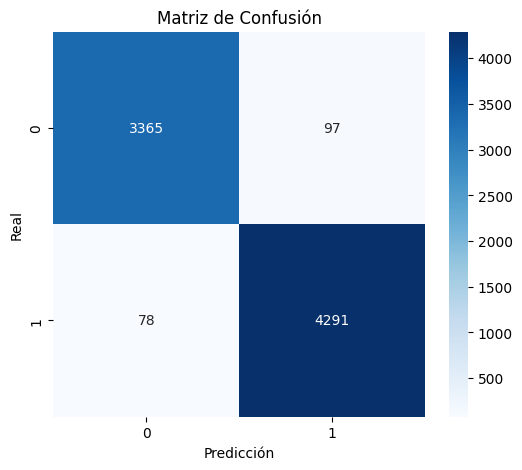

In [11]:

#Aca basicamente lo que hacemos es ver:

#Verdaderos positivos (spam bien detectado)
#Verdaderos negativos (legítimos bien clasificados)
#Falsos positivos
#Falsos negativos

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


# Curva ROC – AUC

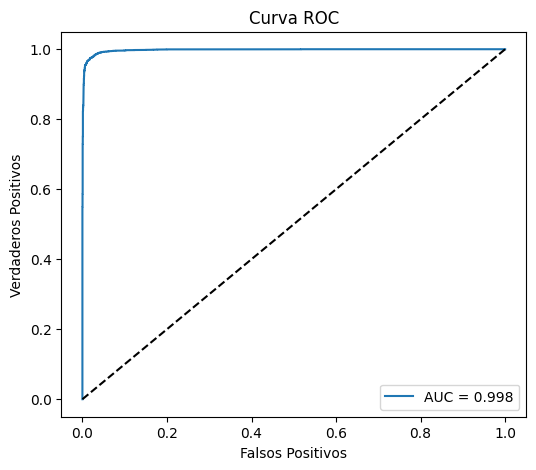

In [12]:

# Curva ROC
y_prob = model.predict_proba(X_test)[:,1]
#ROC nos muestra cómo cambia el rendimiento según el umbral
fpr, tpr, th = roc_curve(y_test, y_prob)
# AUC nos mide el área bajo la curva
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend()
plt.show()
